# Controller

![title](flow_diagram.png)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import os

In [2]:
import sys
from pathlib import Path
path = str(Path(os.getcwd()).parent.parent)
sys.path.insert(0, path)
from breakout.vae.vae import ConvVAE

import_path = str(Path(os.getcwd()).parent.parent.parent)

sys.path.insert(0, import_path)

from WorldModelsExperiments.breakout.model import make_model, _process_frame, simulate

In [3]:
num_actions = 4
    
gamename ='breakout'
optimizer = 'cma'
num_episode = 16
population = 32 # = num_workers * num_worker_trial
    
path = '/home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200420'
    
file_path = path + '/log/'
file_base = gamename+'.'+optimizer+'.'+str(num_episode)+'.'+str(population)
    
vae_path = path + '/tf_vae'
rnn_path = path + '/tf_rnn'
    
record = path + '/record'

In [4]:
model = make_model(rnn_path=os.path.join(rnn_path, 'rnn.json'), vae_path=os.path.join(vae_path, 'vae.json'))

INFO:tensorflow:Model using cpu.


In [5]:
model.load_model(os.path.join(file_path, file_base + '.best.json'))

loading file /home/student/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200420/log/breakout.cma.16.32.best.json


In [6]:
model.weight.shape

(288, 4)

In [9]:
#?
record_file = np.load('/home/student/PycharmProjects/worldmodel/WorldModelsExperiments/breakout/results_200228/record/1393908.npz')
obs_file = record_file['obs']
action_file = record_file['action']
reward_file = record_file['reward']
obs_file.shape

(400, 64, 64, 3)

In [10]:
#?
mu, logvar = model.vae.encode_mu_logvar(obs_file)
mu.shape

(400, 32)

In [7]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    return random_value

In [8]:
def get_z_from_rnn_output(logmix, mean, logstd, z_dim=32,temperatur=1.0):
    chosen_log_pi = np.zeros(z_dim)
    chosen_mu = np.zeros(z_dim)
    chosen_log_sigma = np.zeros(z_dim)
        
    #adjust temp
    pi = np.copy(logmix) #/temperature
    logmix2 = np.exp(pi)
    logmix2 /= logmix2.sum(axis=1).reshape(z_dim, 1)
        
    for j in range(z_dim):
        idx = get_pi_idx(np.random.rand(), logmix2[j])
        chosen_log_pi[j] = idx
        chosen_mu[j] = mean[j, idx]
        chosen_log_sigma[j] = logstd[j,idx]
        
    rand_gaussian = np.random.randn(z_dim)*np.sqrt(temperatur)
    next_z = chosen_mu + np.exp(chosen_log_sigma) * rand_gaussian
    return next_z

In [9]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [58]:
obs_sequence = np.zeros(shape=(1000,210,160,3), dtype=np.uint8)
obs_sequence_vaeview = np.zeros(shape=(1000,64,64,3))
state_sequence = np.zeros(shape=(1000,2,1,256))


appended_reward = []
appended_action = []

In [59]:
obs = model.env.reset()

done = False
seq_counter = 0
total_reward = 0

img_size= (64,64,3)
prev_info = {"ale.lives": model.env.ale.lives()}

while not done:
    model.env.render()
    obs_sequence[seq_counter,:,:,:] = obs
    
    if obs.shape is not img_size:
        obs = _process_frame(obs)
    
    z, mu, logvar = model.encode_obs(obs)
    
    z_dec = model.vae.decode(z.reshape(1,32))
    obs_sequence_vaeview[seq_counter,:,:,:] = z_dec

    action_one_hot, action = model.get_action(z)

    appended_action.append(action)

    obs, reward, done, info = model.env.step(action)
    
    if prev_info['ale.lives']>info['ale.lives']:
        model.env.step(1)
    prev_info = info

    total_reward += reward
    appended_reward.append(reward)
    state_sequence[seq_counter,:,:,:] = model.state
    
    seq_counter+=1
    if done:
        model.env.close()

### Reward

In [60]:
total_reward

4.0

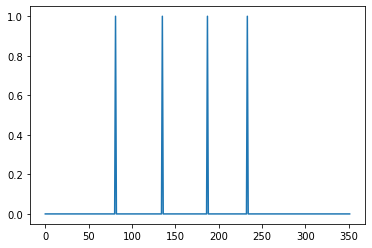

In [61]:
plt.plot(appended_reward)
plt.show()

### Action

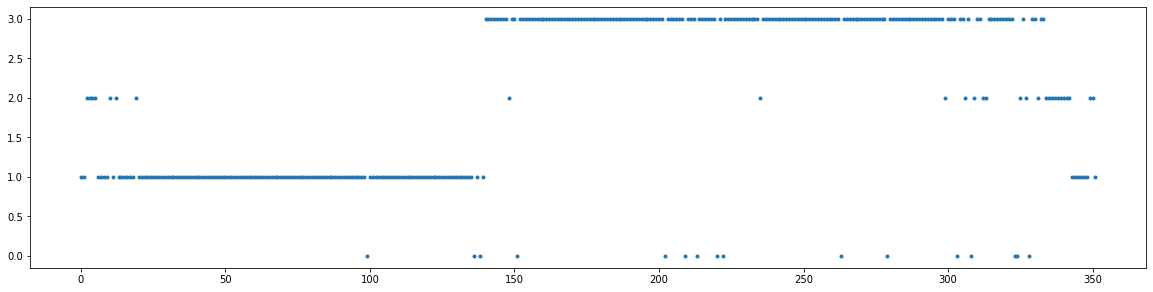

In [62]:
plt.figure(figsize=(20,4.8))
plt.plot(appended_action, '.')
plt.show()

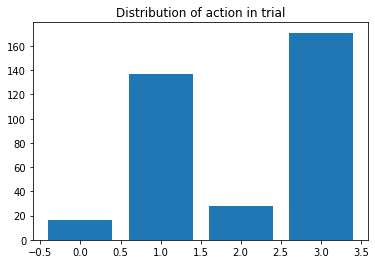

In [63]:
set_action = set(appended_action)
action_counted = []
for action_elem in set_action:
    action_counted.append(appended_action.count(action_elem))

plt.bar(list(set_action), action_counted)
plt.title('Distribution of action in trial')
plt.show()

In [64]:
model.env.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

### State

In [65]:
h_state = []
for idx in range(seq_counter):
    h_state.append(sum(state_sequence[idx][1].reshape(256)))
len(h_state)

352

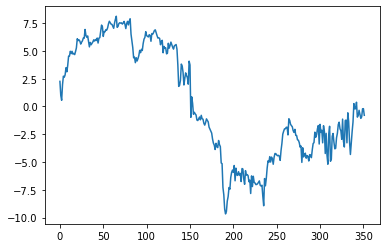

In [66]:
plt.plot(h_state)

plt.show()

## Video Sequence

In [67]:
import base64
import imageio
import IPython
from PIL import Image

In [68]:
def embed_mp4(filename,video):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

### Video Sequence mit observations von env.reset() - "original images"

In [69]:
filename = 'controller4_200420.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(seq_counter):
        video.append_data(obs_sequence[image])
embed_mp4(filename,video)

### Video Sequence mit observations durch VAE Sicht

In [71]:
filename_vae = 'controller4_vae_200420.mp4'
with imageio.get_writer(filename_vae, mode='I') as video_vae:    
    for image in range(seq_counter):
        video_vae.append_data(np.array(obs_sequence_vaeview[image]*255, dtype=np.uint8))
embed_mp4(filename_vae,video)

#### Video Sequence mit obs aus VAE Sicht, aber rescaled

In [72]:
obs_sequence_vaeview_resize = np.zeros(shape=(1000,210,160,3), dtype=np.uint8)
for imageid, image in enumerate(obs_sequence_vaeview):
    image = Image.fromarray((image*255).astype(np.uint8))
    image = image.resize(size=(160,210))
    obs_sequence_vaeview_resize[imageid,:,:,:]=image

In [73]:
obs_sequence_vaeview_resize.dtype

dtype('uint8')

In [30]:
filename_vae_resize = 'controller4_vae__rescale_200228.mp4'
with imageio.get_writer(filename_vae_resize, mode='I', macro_block_size=None) as video_vae_resize:    
    for image in range(seq_counter):
        video_vae_resize.append_data(obs_sequence_vaeview_resize[image])
embed_mp4(filename_vae_resize,video_vae_resize)

# Train Param

In [74]:
with open(file_path+ file_base+ '.hist.json', 'r') as f:
    data = json.load(f)
#h = (t, curr_time, avg_reward, r_min, r_max, std_reward, int(es.rms_stdev()*100000)/100000., mean_time_step+1., int(max_time_step)+1)
data = np.array(data)
data.shape


(464, 9)

In [75]:
data_arr = []
for elem in data:
    data_arr.append([float(elem[2]), float(elem[3]), float(elem[4]), float(elem[5]), float(elem[6])])

In [76]:
required_score = 900.0
with open(file_path + file_base + '.hist_best.json', 'r') as f:
    raw_data = json.load(f)
raw_best_data = np.array(raw_data)
print(raw_best_data.shape)
best_data = []
for bdata in raw_best_data:
    best_data.append([float(bdata[0]), float(bdata[1]), float(bdata[5]), float(bdata[9])])
best_data = np.array(best_data)

(18, 10)


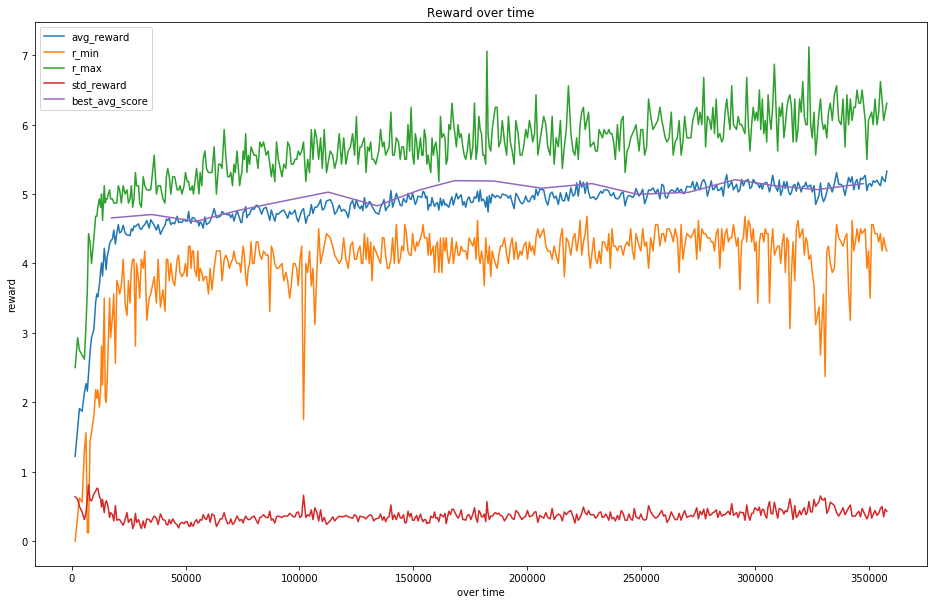

In [77]:
plt.figure(figsize=(16,10))
avg_r, = plt.plot(data[:,1], data[:,2])
min_r, = plt.plot(data[:,1], data[:,3])
max_r, = plt.plot(data[:,1], data[:,4])
std_r, = plt.plot(data[:,1], data[:,5])
best_r, = plt.plot(best_data[:,1], best_data[:,2])
plt.legend([avg_r, min_r, max_r, std_r, best_r], 
           ['avg_reward', 'r_min', 'r_max', 'std_reward', 'best_avg_score'])
plt.xlabel('over time')
plt.ylabel('reward')
plt.title('Reward over time')
plt.show()

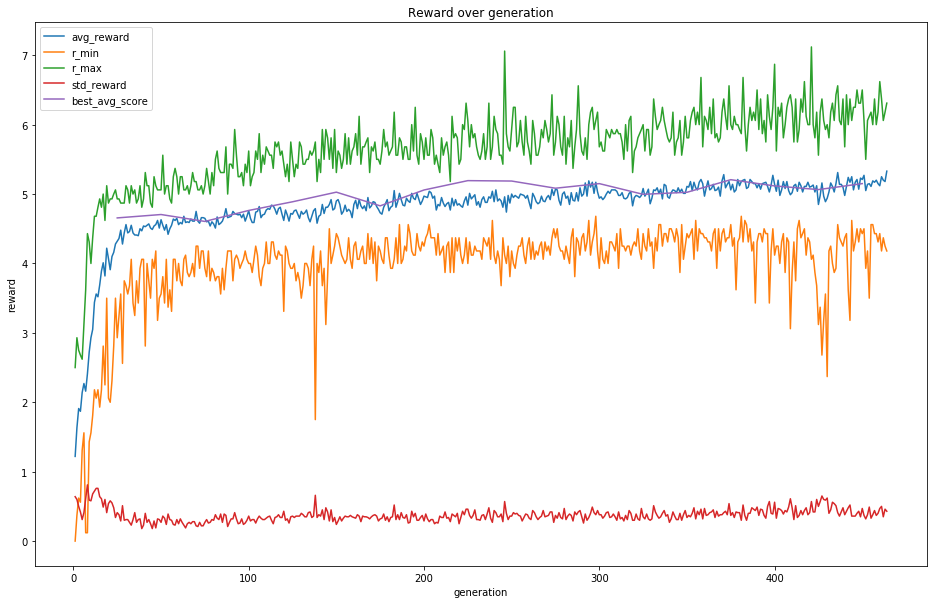

In [78]:
plt.figure(figsize=(16,10))
avg_r, = plt.plot(data[:,0], data[:,2])
min_r, = plt.plot(data[:,0], data[:,3])
max_r, = plt.plot(data[:,0], data[:,4])
std_r, = plt.plot(data[:,0], data[:,5])
best_r, = plt.plot(best_data[:,0], best_data[:,2])
plt.legend([avg_r, min_r, max_r, std_r, best_r], 
           ['avg_reward', 'r_min', 'r_max', 'std_reward', 'best_avg_score'])
plt.xlabel('generation')
plt.ylabel('reward')
plt.title('Reward over generation')
plt.show()

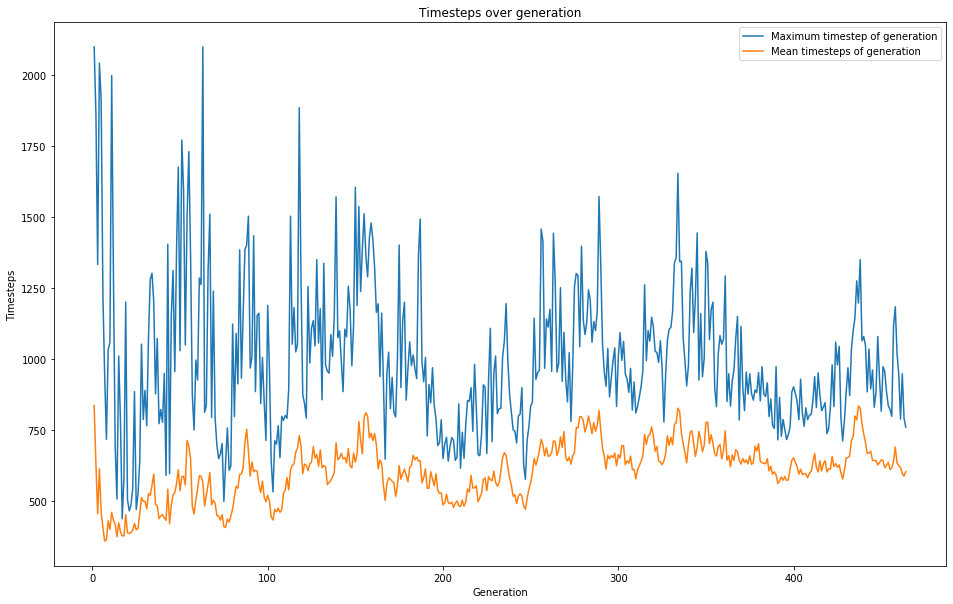

In [79]:
plt.figure(figsize=(16,10))
max_timestep,  = plt.plot(data[:,0],data[:,-1])
mean_timestep, = plt.plot(data[:,0],data[:,7])
plt.legend([max_timestep, mean_timestep],['Maximum timestep of generation', 'Mean timesteps of generation'])
plt.xlabel('Generation')
plt.ylabel('Timesteps')
plt.title('Timesteps over generation')
plt.show()

In [80]:
print('Sum of MEAN of timesteps of each generation: ', int(sum(data[:,7])))
print('Sum of MAX timestep of each generation: ', int(sum(data[:,8])))

print('Each Generation runs 16 episodes. Therefore total timessteps with mean of each geneartion: ', int(sum(data[:,7])*16))

Sum of MEAN of timesteps of each generation:  282225
Sum of MAX timestep of each generation:  462419
Each Generation runs 16 episodes. Therefore total timessteps with mean of each geneartion:  4515605


# Simulate

### render = False

In [82]:
rewards, steps_taken, action_list, obses = simulate(model, train_mode=False, render_mode=False, num_episode=100)

In [83]:
rewards_2, steps_taken_2, action_list_2, obses_2 = simulate(model, train_mode=False, render_mode=False, num_episode=100)

In [84]:
rewards = [int(x) for x in rewards]
rewards_2 = [int(x) for x in rewards_2]

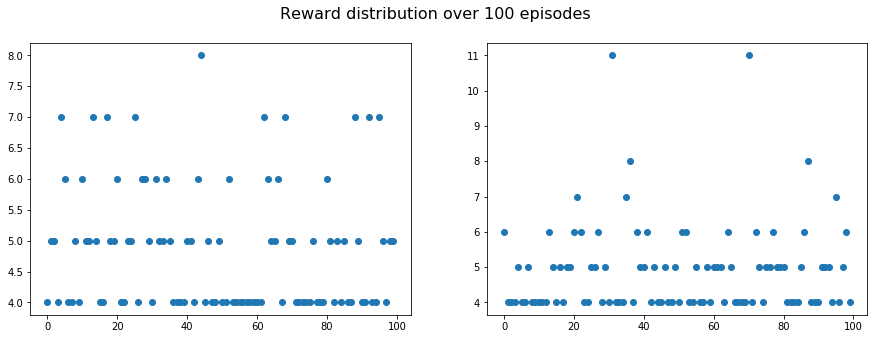

In [86]:
plt.figure(figsize=(15,5))
plt.suptitle('Reward distribution over 100 episodes', size=16)
plt.subplot(1,2,1)
plt.plot(rewards, 'o')
plt.subplot(1,2,2)
plt.plot(rewards_2, 'o')
plt.show()

### Reward == 0

In [87]:
zero_reward = []
counter = 0
for trial in rewards:
    if trial==4:
        zero_reward.append(counter)
    counter +=1


Trial  0
[8, 155, 34, 152]
Trial  3
[17, 140, 30, 163]
Trial  6
[11, 132, 34, 167]
Trial  7
[20, 135, 33, 160]
Trial  9
[18, 133, 29, 171]
Trial  15
[23, 131, 36, 159]
Trial  16
[10, 171, 42, 140]
Trial  21
[14, 137, 33, 173]
Trial  22
[15, 152, 32, 154]


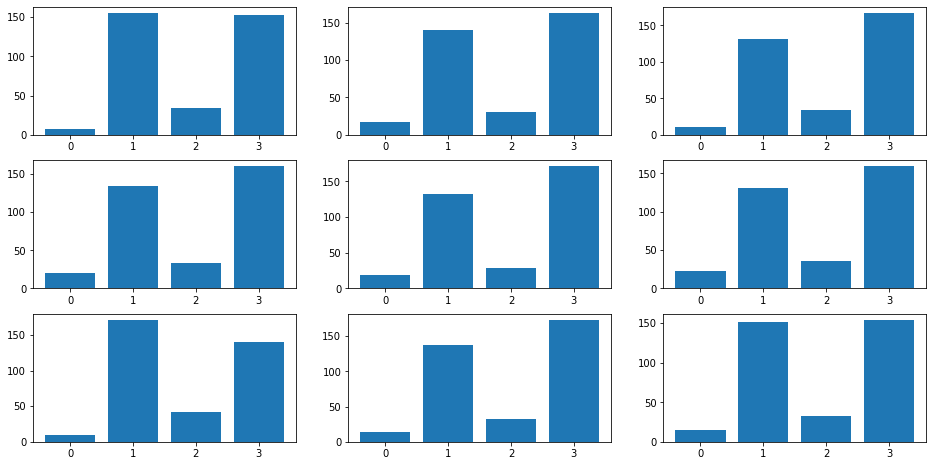

In [88]:
zero_reward_snap = zero_reward[:9]

counter =1
plt.figure(figsize=(16,8))
for trial in zero_reward_snap:
    print('Trial ', trial)
    action_set = set(action_list[trial])
    actions_counted = []
    for elem in action_set:
        actions_counted.append(action_list[trial].count(elem))
        
    plt.subplot(3,3, counter)
    plt.bar(list(action_set), actions_counted)
    print(actions_counted)
    counter += 1
    
plt.show()

### Reward == 2

In [47]:
reward_two = []
counter = 0
for trial in rewards:
    if trial==2:
        reward_two.append(counter)
    counter +=1

Trial  0
[90, 240, 450, 36]
Trial  1
[133, 249, 338, 77]
Trial  3
[76, 191, 507, 23]
Trial  10
[118, 237, 365, 79]
Trial  13
[78, 213, 490, 18]
Trial  19
[121, 236, 359, 72]
Trial  20
[52, 220, 495, 27]
Trial  23
[61, 230, 476, 22]
Trial  25
[65, 232, 474, 27]


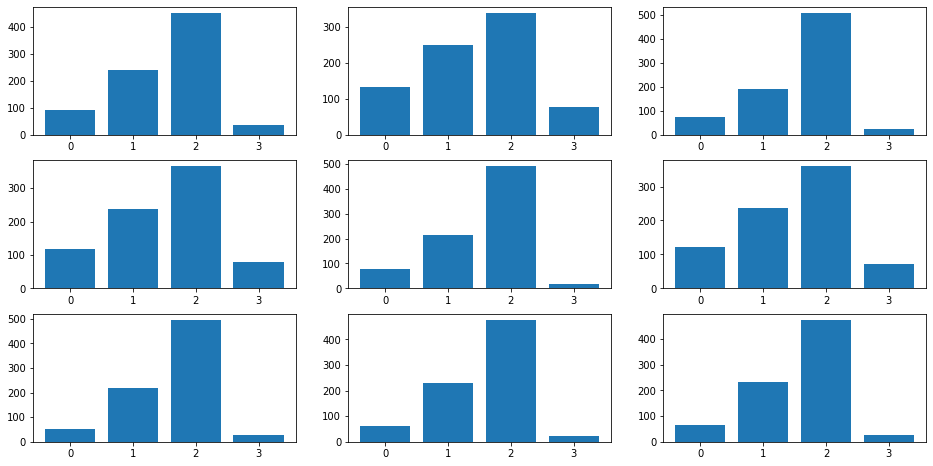

In [48]:
reward_two_snap = reward_two[:9]

counter = 1
plt.figure(figsize=(16,8))
for trial in reward_two_snap:
    print('Trial ', trial)
    actions_set = set(action_list[trial])
    actions_counted = []
    for elem in actions_set:
        actions_counted.append(action_list[trial].count(elem))
        
    plt.subplot(3,3, counter)
    plt.bar(list(action_set), actions_counted)
    print(actions_counted)
    
    counter += 1
    
plt.show()